**Group Details:**

- Name: ID: אדר חזאזי גרש 322262361
- Name: ID: ליעם קלס 208252882
- Name: ID: עינב טולדו 323716365

In [ ]:
#@title Helper Functions and Imports

from pydrive2.auth import GoogleAuth
from google.colab import drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Some visual settings
sns.set()
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14

RENT_ID = '1R6v2uHpFyNb1z2DT0M_JHTUE3PHFFYmu'
SOCIORANK_ID = '1gc57mT5zgIb-XeVsMfCphnWTRz1-dmLj'

def load_df(drive_id, **load_kwargs):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  download = drive.CreateFile({'id': drive_id})
  filename = '{}.csv'.format(drive_id)
  download.GetContentFile(filename)
  return pd.read_csv(filename, **load_kwargs)




# Introduction to Data Science - Lab \#2

## Exploratory Data Analysis

### Case Study: Rental Listings in Jerusalem
In this lab we will practice our exploratory data analysis skills using real data!

We will explore data of rental pricings in Jersualem.
The dataset consists of listings published in https://www.komo.co.il/ during the summer of 2022.

We will use two python packages for visualizing the data: `matplotlib` (and specifically its submodule `pyplot` imported here as `plt`) and `seaborn` (imported as `sns`). Seaborn is a package that "wraps" matplotlib and introduces more convenient functions for quickly creating standard visualizations based on dataframes.

Please **breifly** go over this [quick start guide](https://matplotlib.org/stable/tutorials/introductory/quick_start.html) to matplotlib, the [first](https://seaborn.pydata.org/tutorial/introduction.html) seaborn introduction page until the "Multivariate views on complex datasets" section (not included), and the [second](https://seaborn.pydata.org/tutorial/function_overview.html) introduction page until the "Combining multiple views on the data" section.



In [ ]:
#@title Loading the dataset
rent_df = load_df(RENT_ID)[['propertyID','neighborhood','monthlyRate','mefarsem','rooms','floor','area','entry','description','numFloors']]
rent_df = rent_df.drop_duplicates(subset='propertyID').reset_index(drop=True)
rent_df_backup_for_exercise = rent_df.copy()
clean_df_area_filtered = None
clean_df = None

Let's print a random sample:

In [ ]:
np.random.seed(2)
rent_df.sample(5)

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors
403,3981729,גבעת מרדכי,4500.0,private,3.0,6.0,62.0,10/08/2022,"דירה יפה, נקיה, ומשופצת לאחרונה. מתאים למשפחות...",8.0
457,3991612,קריית משה,3000.0,private,3.5,3.0,NaN,NaN,במחיר חסר תקדים! דירה בת 3.5 חדרים. ברחוב שושנ...,4.0
500,3976987,הגבעה הצרפתית,7800.0,private,4.0,11.0,118.0,10/08/2022,"בבניין שתי מעליות, מעלית שבת. חניון תת קרקעי ע...",13.0
84,3985356,גילה,3600.0,private,2.0,1.0,60.0,10/08/2022,"מקום מדהים ,קומה ראשונה,תחנת אוטובוס,גני ילדים...",1.0
109,3994714,קריית יובל,3500.0,private,2.0,1.0,55.0,10/08/2022,"להשכרה דירת 3 חדרים שהפכו אותה ל2 חדרים, עם סל...",4.0


And print some summary statistics:

In [ ]:
rent_df.describe(include='all')

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors
count,6.120000e+02,612,612.000000,612,612.000000,611.000000,295.000000,292,596,610.000000
unique,NaN,54,NaN,2,NaN,NaN,NaN,17,578,NaN
top,NaN,קריית יובל,NaN,private,NaN,NaN,NaN,10/08/2022,"להשכרה, דירה, קומה ראשונה, בירושלים",NaN
freq,NaN,66,NaN,600,NaN,NaN,NaN,259,8,NaN
mean,3.981582e+06,NaN,4717.393791,NaN,2.927288,1.916530,87.664407,NaN,NaN,3.908197
std,6.525543e+04,NaN,2195.215139,NaN,1.007350,1.581006,277.004591,NaN,NaN,1.978065
min,2.494041e+06,NaN,0.000000,NaN,1.000000,-2.000000,1.000000,NaN,NaN,1.000000
25%,3.981694e+06,NaN,3500.000000,NaN,2.000000,1.000000,42.000000,NaN,NaN,3.000000
50%,3.987901e+06,NaN,4400.000000,NaN,3.000000,2.000000,60.000000,NaN,NaN,4.000000
75%,3.992605e+06,NaN,5800.000000,NaN,3.500000,3.000000,85.000000,NaN,NaN,4.000000


The variables we will focus on are:
1. neighborhood: The hebrew name of the neighborhood in jerusalem where the listing is located
2. monthlyRate: The monthly rate (שכר דירה) in shekels
3. rooms: The number of rooms in the apartment
4. floor: The floor in which the apartment is located
5. area: The area of the apartment in squared meters
6. numFloors: The total number of floors in the building

**What is the distribution of prices in this dataset?**

Q: Plot a histogram with 30 bins of the monthly rates in this dataset:

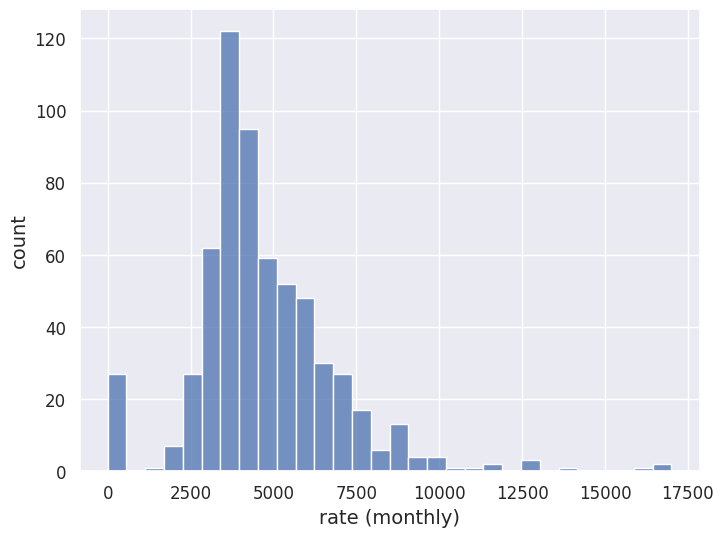

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.histplot(x='monthlyRate', data=rent_df, bins=30)
plt.xlabel("rate (monthly)")
plt.ylabel("count");

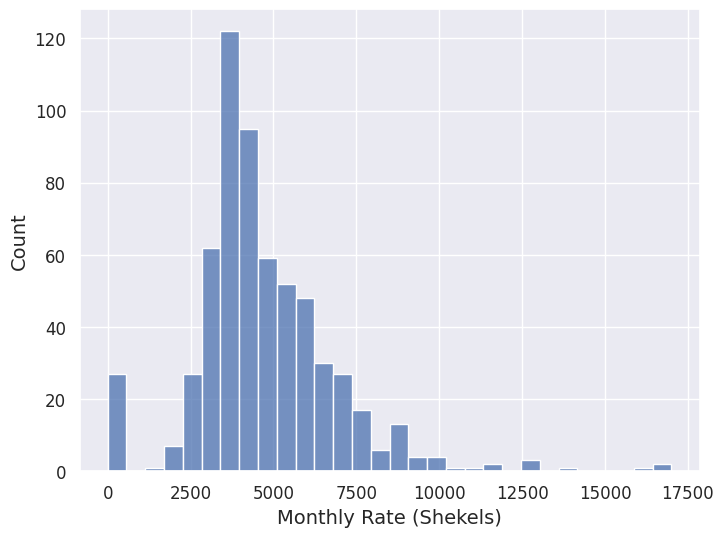

In [ ]:
# @title Solution 1
plt.figure(figsize=(8,6))
sns.histplot(rent_df['monthlyRate'], bins=30)
plt.xlabel("Monthly Rate (Shekels)");

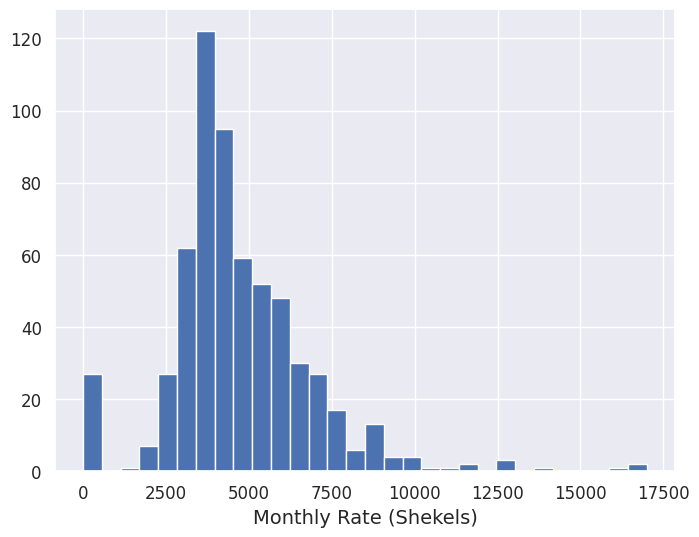

In [ ]:
# @title Solution 2
rent_df["monthlyRate"].hist(bins=30, figsize=(8,6))
plt.xlabel("Monthly Rate (Shekels)");


<br><br><br><br><br><br><br>
We see that the prices distribution peaks around ~3500 Shekels and that it is right skewed, as there are some very expensive apartments.
We can also see a peak at zero which makes sense as sometimes listings do not include a price. We would want to filter those out when we analyze prices later on.

Q: Print the number of listings that have no monthly rate:


In [ ]:
# @title Solution
print("Number of apartments without a price: ", rent_df['monthlyRate'].value_counts()[0].round(3))

Number of apartments without a price:  25


We want to remove those listings, but we don't want to lose these entries, as we might want to know how many and what type of outliers we originally removed. So we create another dataframe that has the listings we removed and the reason for removal.

In [ ]:
outlier_df = pd.DataFrame(columns=rent_df.columns.to_list()+['reason']) # will save the outliers

outliers = rent_df[rent_df['monthlyRate'] <= 0].reset_index(drop=True)
outliers['reason']= "monthlyRate <= 0"
outlier_df = pd.concat([outlier_df, outliers], axis=0, ignore_index=True).drop_duplicates().reset_index(drop=True)
outlier_df.tail()

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors,reason
20,3983978,קריית משה,0.0,private,4.0,3.0,100.0,10/08/2022,דירת 4 חדרים - במצב מצויין - שמורה ביותר כולל ...,5.0,monthlyRate <= 0
21,3985184,נווה יעקב,0.0,private,4.0,1.0,68.0,10/08/2022,"דירה במצב שמור מאד. ממוזגת, 2 חדרי שירותים (אח...",2.0,monthlyRate <= 0
22,3952750,מוסררה,0.0,private,5.5,1.0,180.0,10/08/2022,"להשכרה דירה מפוארת, במרכז העיר מרחק הליכה מהע...",4.0,monthlyRate <= 0
23,3988157,גבעת שאול,0.0,private,5.0,1.0,140.0,10/08/2022,בית פרטי שתי קומות שימש בעבר לגן מתאים כל מתרה...,2.0,monthlyRate <= 0
24,3981160,גבעת משואה,0.0,private,6.0,-2.0,NaN,NaN,"מול נוף עוצר נשימה, 6 חדרים מרווחים, מרפסת 70 ...",5.0,monthlyRate <= 0


We will now remove those listings and save the result to a new variable `clean_df`:

In [ ]:
clean_df = rent_df[rent_df['monthlyRate'] > 0].reset_index(drop=True)

**What is the distribution of the number of rooms?**

Q: Use `sns.countplot` to compare the counts of listings with different numbers of rooms. Plot all bars in the same [color](https://matplotlib.org/stable/tutorials/colors/colors.html) of your choice.


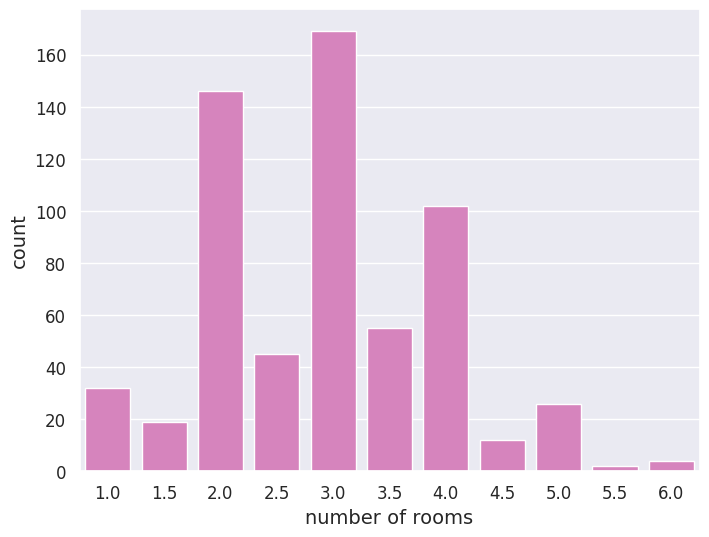

In [ ]:
fig2 = plt.figure(figsize=(8,6))
sns.countplot(x='rooms', data=rent_df, color = 'tab:pink')
plt.xlabel("number of rooms")
plt.ylabel("count");

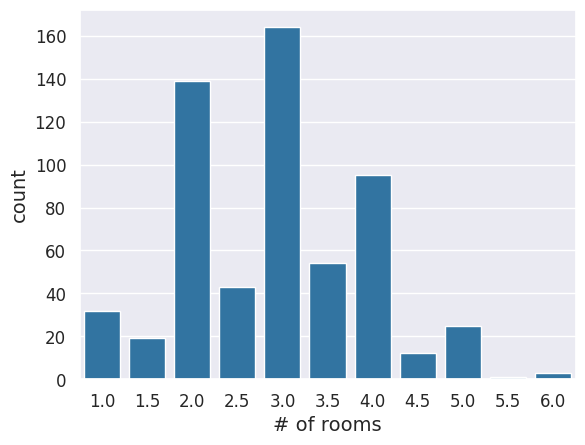

In [ ]:
# @title Solution
if clean_df is None:
  print("Can't run until 'clean_df' is created!")
else:
  sns.countplot(x='rooms', data=clean_df, color='tab:blue')
  plt.xlabel("# of rooms");

The distribution peaks at three rooms and we also see that "half rooms" are less common.

**Can we see an association between apartment area and price?**

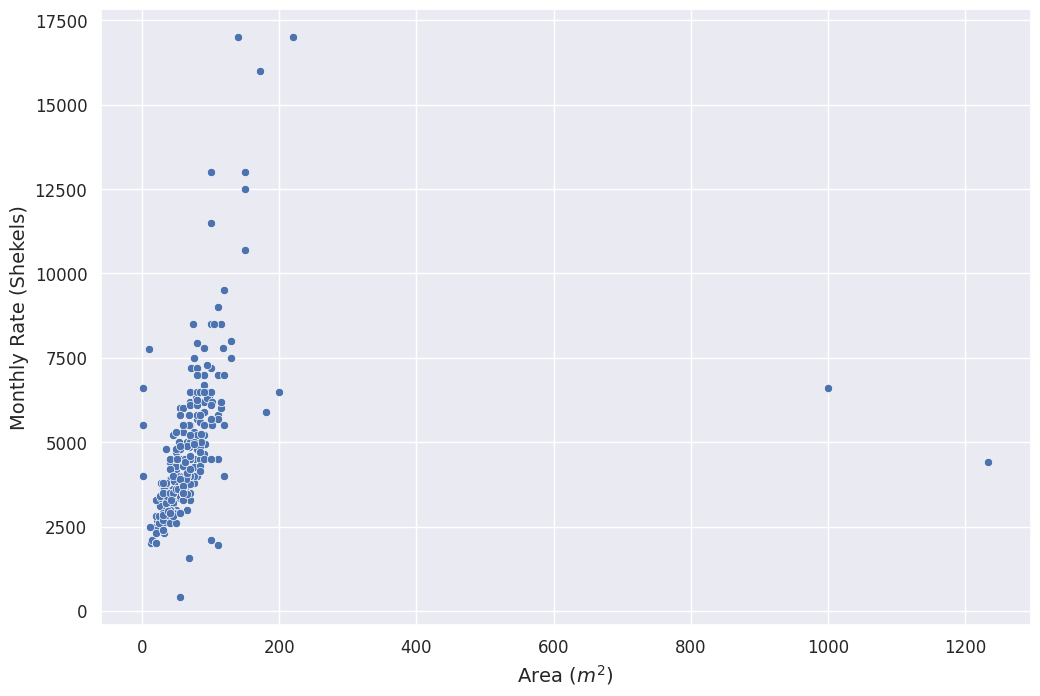

In [ ]:
if clean_df is None:
  print("Can't run until 'clean_df' is created!")
else:
  plt.figure(figsize=(12,8))
  sns.scatterplot(x='area', y='monthlyRate', data=clean_df)
  plt.ylabel("Monthly Rate (Shekels)")
  plt.xlabel("Area ($m^2$)");

We see clear outliers here! We know that area is measured in squared meters and it is unlikely that there are any apartments of ~1000$m^2$.

Let's look at those samples to see if we can understand what happend there:

In [ ]:
if clean_df is None:
  print("Can't run until 'clean_df' is created!")
else:
  display(clean_df.sort_values('area', ascending=False).head(4))

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors
185,3964340,תלפיות,4400.0,private,2.0,2.0,1234.0,10/08/2022,NaN,3.0
543,3956561,זכרון משה,6600.0,private,3.5,3.0,1000.0,01/07/2022,דירה מהממת בלב ירושלים. צמודה לרכבת הקלה- תחנת...,3.0
576,3974914,תלפיות,17000.0,private,5.0,3.0,220.0,10/08/2022,"דירת 5 חדרים ענקית ומהממת, בבנין בוטיק ויחודי ...",4.0
566,3988577,פסגת זאב,6500.0,private,5.5,1.0,200.0,10/08/2022,"דירה בת 5.5 חדרים . בקומה התחתונה סלון , מטבח ...",3.0


And inspect the description of one of those listings:

In [ ]:
if clean_df is None:
  print("Can't run until 'clean_df' is created!")
else:
  display(clean_df.at[543,'description'])

'דירה מהממת בלב ירושלים. צמודה לרכבת הקלה- תחנת הדוידקה. 3 חדרים ענקיים ולכל חדר מרפסת גדולה. חלל כניסה עם פינת ישיבה. מתאימה מאוד ל- 3 שותפים'

Clearly not a 1000 m^2 apartment...

Q: Save a new dataframe named `clean_df_area_filtered` with all listings with area smaller than 800 m^2. Again, add the removed outliers to the outliers_df dataframe.

Plot again the scatter of area vs. monthly rate after removing the outliers.

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors,reason
22,3952750,מוסררה,0.0,private,5.5,1.0,180.0,10/08/2022,"להשכרה דירה מפוארת, במרכז העיר מרחק הליכה מהע...",4.0,monthlyRate <= 0
23,3988157,גבעת שאול,0.0,private,5.0,1.0,140.0,10/08/2022,בית פרטי שתי קומות שימש בעבר לגן מתאים כל מתרה...,2.0,monthlyRate <= 0
24,3981160,גבעת משואה,0.0,private,6.0,-2.0,NaN,NaN,"מול נוף עוצר נשימה, 6 חדרים מרווחים, מרפסת 70 ...",5.0,monthlyRate <= 0
25,3964340,תלפיות,4400.0,private,2.0,2.0,1234.0,10/08/2022,NaN,3.0,area > 800
26,3956561,זכרון משה,6600.0,private,3.5,3.0,1000.0,01/07/2022,דירה מהממת בלב ירושלים. צמודה לרכבת הקלה- תחנת...,3.0,area > 800


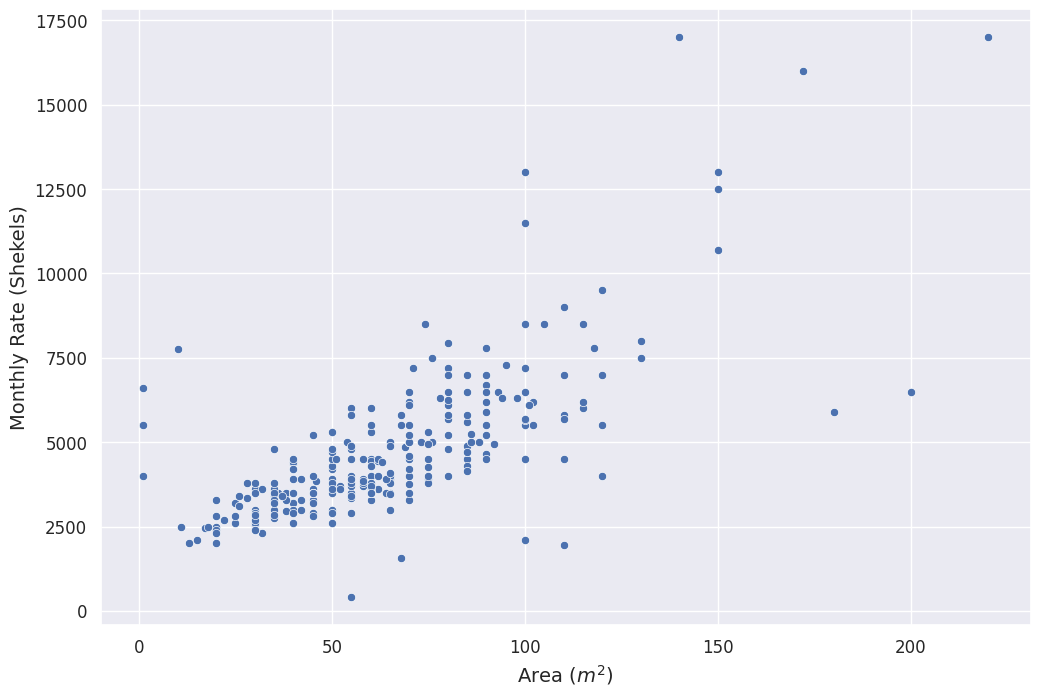

In [ ]:
clean_df_area_filtered = clean_df[clean_df["area"] < 800]
plt.figure(figsize=(12,8))
sns.scatterplot(x='area', y='monthlyRate', data=clean_df_area_filtered)
plt.ylabel("Monthly Rate (Shekels)")
plt.xlabel("Area ($m^2$)");

outliers = clean_df[clean_df['area'] > 800].reset_index(drop=True)
outliers['reason']= "area > 800"
outlier_df = pd.concat([outlier_df, outliers], axis=0, ignore_index=True).drop_duplicates().reset_index(drop=True)
outlier_df.tail()

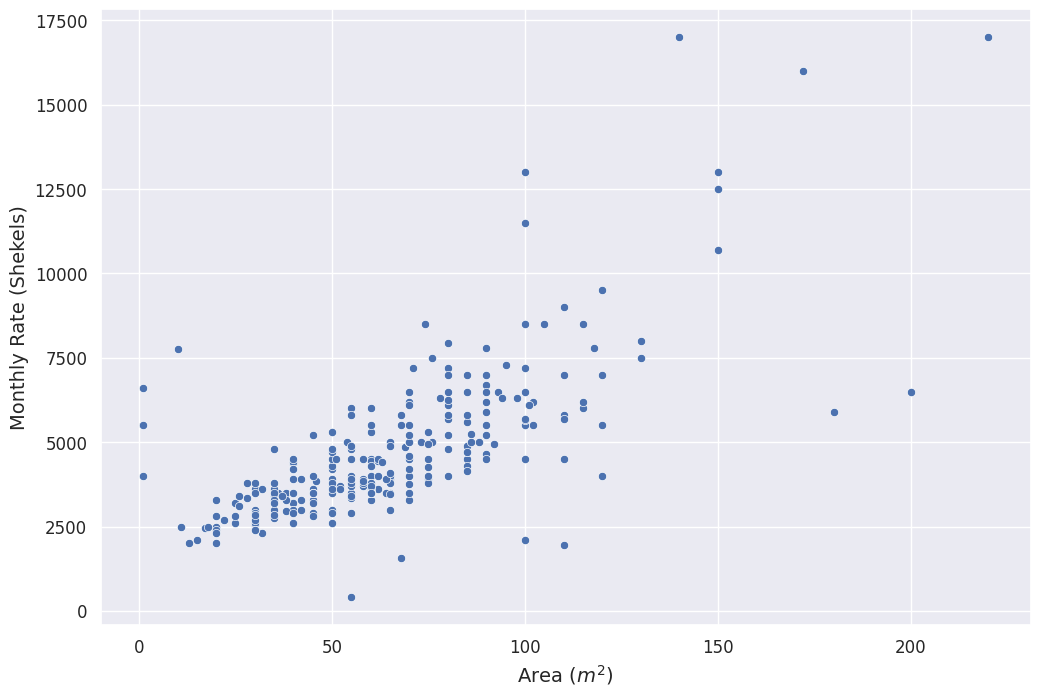

In [ ]:
# @title Solution
if clean_df is None:
  print("Can't run until 'clean_df' is created!")
elif outlier_df is None:
  print("Can't run until 'outlier_df' is created!")
else:
  # save outliers
  outliers = clean_df[clean_df['area'] >= 800].reset_index(drop=True)
  outliers['reason']= "'area' >= 800"
  outlier_df = pd.concat([outlier_df, outliers], axis=0, ignore_index=True).drop_duplicates().reset_index(drop=True)

  # remove the outliers from the dataset
clean_df_area_filtered = clean_df[clean_df['area'] < 800].reset_index(drop=True)
plt.figure(figsize=(12,8))
sns.scatterplot(x='area', y='monthlyRate', data=clean_df_area_filtered)
plt.xlabel("Area ($m^2$)")
plt.ylabel("Monthly Rate (Shekels)");


Again, we see some strange behavior of apartments with almost zero area but with a high monthly rate. Let's check them out:

We start with all apartments with an area between 0 to 25 $m^2$:

In [ ]:
# Show all apartments with area between 0 and 25
clean_df_area_filtered[clean_df_area_filtered['area'].between(0,25)]

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors
0,3994505,קריית יובל,2000.0,private,1.0,2.0,13.0,10/08/2022,"יחידת דיור להשכרה ברחוב הראשי של קריית יובל, ה...",2.0
1,3981298,רחביה,2450.0,private,1.0,1.0,17.0,10/08/2022,דירת יחיד 17 מטר כולל מרפסת קטנה,3.0
3,3993997,בית וגן,2100.0,private,1.0,0.0,15.0,10/08/2022,"דירת חדר, כ-15 מ""ר, במיקום מרכזי אך שקט, משופצ...",3.0
5,3993552,הר נוף,2000.0,private,1.0,0.0,20.0,10/08/2022,"יחידה משופצת ליחיד או למשרד , מיקום מצוין",4.0
6,3972039,גבעת שאול,2700.0,private,1.0,0.0,22.0,10/08/2022,"דירת חדר כחדשה , כניסה נפרדת ללא וועד בית , מו...",1.0
7,3988096,המושבה הגרמנית,2500.0,private,1.0,0.0,18.0,10/08/2022,רלוונטי לנשים בלבד. ללא עישון. ללא חיות מחמד. ...,1.0
8,3992809,נחלאות,3200.0,private,1.0,2.0,25.0,10/08/2022,"הדירה המגניבה בנחלאות, מתפנה אחרי תקופה ארוכה ...",2.0
10,3983516,הגבעה הצרפתית,2000.0,private,1.0,2.0,20.0,10/08/2022,"דירת חדר קטנה, מסוגננת ונחמדה, מתאימה ליחיד בל...",13.0
12,3987706,נחלאות,2800.0,private,1.0,0.0,20.0,10/08/2022,"להשכרה, דירה, בירושלים ברחוב חצור בנחלאות. דיר...",2.0
13,3991842,קטמון הישנה,2500.0,private,1.0,1.0,20.0,10/08/2022,דירת חדר ליחיד באזור יפייפה ושקט בקטמון הישנה....,4.0


Some make sense and others do not. Let's focus on the expensive ones (between 5,000 and 10,000 shekels):

In [ ]:
# Show all apartments with area between 0 and 25 that also have a price between 5000 and 10000
if clean_df_area_filtered is None:
  print("Can't run until 'clean_df_area_filtered' is created!")
else:
  display(clean_df_area_filtered[clean_df_area_filtered['area'].between(0,25) & clean_df_area_filtered['monthlyRate'].between(5000, 10000)])

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors
197,3984483,ארנונה,6600.0,private,4.0,2.0,1.0,01/09/2022,"בשכונת ארנונה, רח’ שלום יהודה, דירת 4 חדרים מש...",4.0
234,3985019,פסגת זאב,5500.0,private,4.0,3.0,1.0,10/08/2022,להשכרה 4 חדרים מרווחת עם מרפסת סוכה שטופת שמש ...,4.0
235,3944204,בית הכרם,7750.0,private,4.0,3.0,10.0,01/09/2022,"בבניין חדש, מושקעת, מוארת, מאווררת רח’ שקט, רח...",5.0
274,3982178,נווה יעקב,5500.0,private,5.0,1.0,1.0,10/08/2022,"דירה במצב מעולה!! נוף, מוארת, מאווררת, מרפסת סוכה",4.0


Those are clearly wrong too...
Besides that the relationship between the area and the price seems linear.
Let's remove these outliers too:



In [ ]:
#remove the outliers
if clean_df_area_filtered is None:
  print("Can't run until 'clean_df_area_filtered' is created!")
elif outlier_df is None:
  print("Can't run until 'outlier_df' is created!")
else:
  non_ouliers = clean_df_area_filtered['area'] > 10 # get non outliers series of true/false

  # save outliers
  outliers = clean_df_area_filtered[~non_ouliers].reset_index(drop=True) # get the outliers
  outliers['reason']= "'area' <= 10"
  outlier_df = pd.concat([outlier_df, outliers], axis=0, ignore_index=True).drop_duplicates().reset_index(drop=True)

  # remove them
  clean_df_area_filtered = clean_df_area_filtered[non_ouliers].reset_index(drop=True)

#### **Can we see a different pattern for top floor apartments?**
Q: Plot again a scatter of area vs. monthly rate. This time distinguish (by color / marker style or both) between apartments that are in the top floor and the rest of the apartments. (To do that you should create a new column in `clean_df_area_filtered` called `is top floor` and set it to 1 if the apartment is in the top floor and 0 otherwise.)

<Axes: xlabel='Area (m^2)', ylabel='Monthly Rate (Shekels)'>

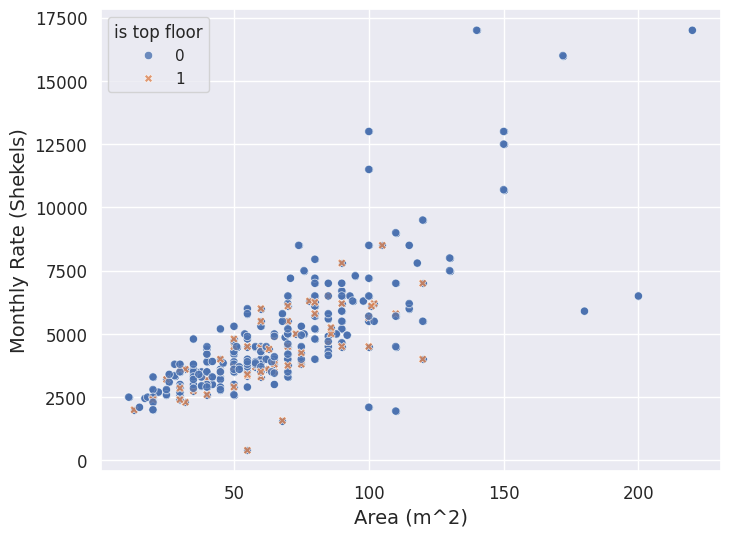

In [ ]:
plt.figure(figsize = (8,6))
sns.scatterplot(x = "area", y = "monthlyRate", data = clean_df_area_filtered)
plt.xlabel("Area (m^2)")
plt.ylabel("Monthly Rate (Shekels)")

clean_df_area_filtered["is top floor"] = 0
clean_df_area_filtered.loc[clean_df_area_filtered['floor'] == clean_df_area_filtered['numFloors'], "is top floor"] = 1
#print(clean_df_area_filtered)
sns.scatterplot(x='area', y='monthlyRate', data=clean_df_area_filtered, alpha=0.8, hue='is top floor', style="is top floor")


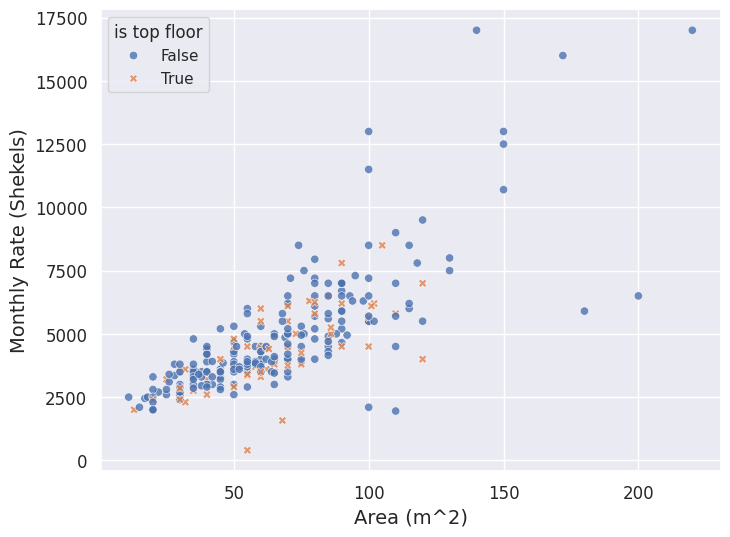

In [ ]:
# @title Solution

if clean_df_area_filtered is None:
  print("Can't run until 'clean_df_area_filtered' is created!")
else:
  clean_df_area_filtered['is top floor'] = clean_df_area_filtered['floor'] == clean_df_area_filtered['numFloors']
  plt.figure(figsize=(8,6))
  sns.scatterplot(x='area', y='monthlyRate', data=clean_df_area_filtered, alpha=0.8, hue='is top floor', style="is top floor");
  plt.xlabel("Area (m^2)")
  plt.ylabel("Monthly Rate (Shekels)");

We can take a deeper look on the apartments with the very high monthly rate (to see if those are outliers or not):

In [ ]:
if clean_df_area_filtered is None:
  print("Can't run until 'clean_df_area_filtered' is created!")
else:
  display(clean_df_area_filtered[clean_df_area_filtered['monthlyRate'] > 11000])

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors,is top floor
198,3956418,רחביה,13000.0,agent,4.0,1.0,100.0,NaN,Beautifully renovated furnished authentic arab...,3.0,False
236,3985051,טלביה,17000.0,private,4.0,4.0,140.0,10/08/2022,בקינג דיוד רזדנס דירת 4 חדרים להשכרה ללא תיו...,10.0,False
257,3982363,רחביה,16000.0,private,5.0,2.0,172.0,10/08/2022,"הזדמנות נדירה!!! ברחוב רד""ק, בנקודה הכי קרובה ...",5.0,False
260,3980016,אבו תור,12500.0,private,5.0,0.0,150.0,10/08/2022,"דירת דופלקס ענקית 150 מ""ר עם כניסה נפרדת. הדיר...",4.0,False
263,3994228,בית ישראל,11500.0,private,5.0,1.0,100.0,10/08/2022,"דירה ממוקמת בלב ירושלים שכונת בית ישראל, מרפסת...",3.0,False
266,3974914,תלפיות,17000.0,private,5.0,3.0,220.0,10/08/2022,"דירת 5 חדרים ענקית ומהממת, בבנין בוטיק ויחודי ...",4.0,False
270,3981999,תלפיות,13000.0,private,5.0,4.0,150.0,10/08/2022,דירת 5 חדרים חדשה! בדירה יש מרפסת מרפסת שירו...,5.0,False


We can see some representation of the more expensive neighborhoods of Jerusalem here.. More on the neighborhoods later on!

**Is there also a relation between the number of rooms and the listing price?**

Q: Create a visualization that compares the distribution of prices for different number of rooms. Your visualization should provide information about central tendency (mean/median/mode) and some information about the distribution of individual values around it (standard deviation/interquartile range) for each number of rooms. Also, show the real prices of the listings per number of rooms.

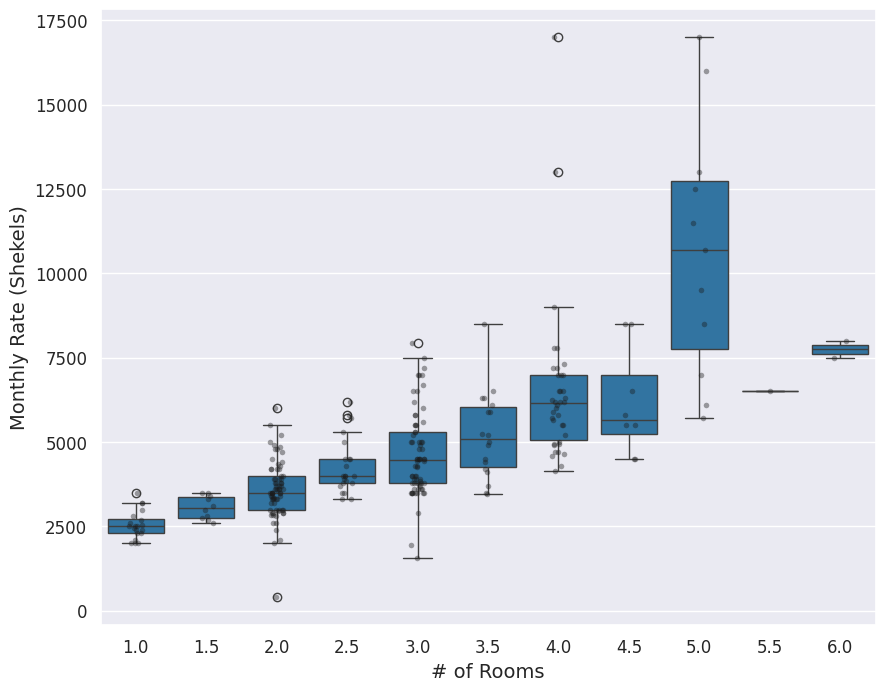

In [ ]:
# @title Solution
if clean_df_area_filtered is None:
  print("Can't run until 'clean_df_area_filtered' is created!")
else:
  plt.figure(figsize=(10,8))
  sns.boxplot(x='rooms', y='monthlyRate', data=clean_df_area_filtered, color='tab:blue')
  sns.stripplot(x='rooms', y='monthlyRate', alpha=0.4 ,size=4,color='k',data=clean_df_area_filtered)
  plt.xlabel("# of Rooms")
  plt.ylabel("Monthly Rate (Shekels)");

  # Or:
  # plt.figure(figsize=(10,8))
  # sns.barplot(x='rooms', y='monthlyRate', data=clean_df_area_filtered, color='tab:blue', errorbar=None, estimator='median')
  # # Can also use mean but median is more informative in this case as prices are skewed...
  # sns.stripplot(x='rooms', y='monthlyRate', alpha=0.4 ,color='k',data=clean_df_area_filtered)
  # plt.xlabel("# of Rooms")
  # plt.ylabel("Monthly Rate (Shekels)");

  #Violin plot completly fails for very small subsets:
  # plt.figure(figsize=(10,8))
  # sns.violinplot(x='rooms', y='monthlyRate', data=clean_df_area_filtered, color='tab:blue')
  # plt.xlabel("# of Rooms")
  # plt.ylabel("Monthly Rate (Shekels)");


Now that we finished pre-processing the data, we can see the state of our outliers VS the data that remains:

In [ ]:
if outlier_df is None:
  print("Can't run until 'outlier_df' is created!")
else:
  # describe the outlier data
  display(outlier_df.groupby('reason').describe())
  print(f"Proportion removed: {100*len(outlier_df) / (len(outlier_df)+len(clean_df_area_filtered)):.0f} %")

monthlyRate                                               \
                       count    mean          std     min     25%     50%   
reason                                                                      
'area' <= 10             5.0  5870.0  1399.821417  4000.0  5500.0  5500.0   
'area' >= 800            2.0  5500.0  1555.634919  4400.0  4950.0  5500.0   
area > 800               2.0  5500.0  1555.634919  4400.0  4950.0  5500.0   
monthlyRate <= 0        25.0     0.0     0.000000     0.0     0.0     0.0   

                                 rooms        ...    area         numFloors  \
                     75%     max count  mean  ...     75%     max     count   
reason                                        ...                             
'area' <= 10      6600.0  7750.0   5.0  3.90  ...     1.0    10.0       5.0   
'area' >= 800     6050.0  6600.0   2.0  2.75  ...  1175.5  1234.0       2.0   
area > 800        6050.0  6600.0   2.0  2.75  ...  1175.5  1234.0       2.0   
monthlyRate <= 0     0.0     0.0  25.0  3.28  ...    99.0  4554.0      25.0   

                                                            
                  mean       std  min  25%  50%  75%   max  
reason                                                      
'area' <= 10      3.80  1.095445  2.0  4.0  4.0  4.0   5.0  
'area' >= 800     3.00  0.000000  3.0  3.0  3.0  3.0   3.0  
area > 800        3.00  0.000000  3.0  3.0  3.0  3.0   3.0  
monthlyRate <= 0  3.48  2.293469  1.0  2.0  3.0  4.0  11.0  

[4 rows x 40 columns]

Proportion removed: 11 %


# Submission Exercises

## Part 1: Diving deeper into rental prices

We will create a copy of the dataset and work on that. We want to make sure that we do not modify the original dataset.

In [ ]:
# @title Part 1 - Create a DataFrame
part1_df = rent_df_backup_for_exercise.copy()

Let's go back to the distribution of monthly rental prices in the dataset. Are there interesting trends in the distribution that we missed in the visualizations before?

**Use only `part1_df` for the coding questions in this part**



### **Question 1**
Plot 3 different histograms of the monthly prices with 20, 60 and 120 bins respectively, each in a different axis/figure.


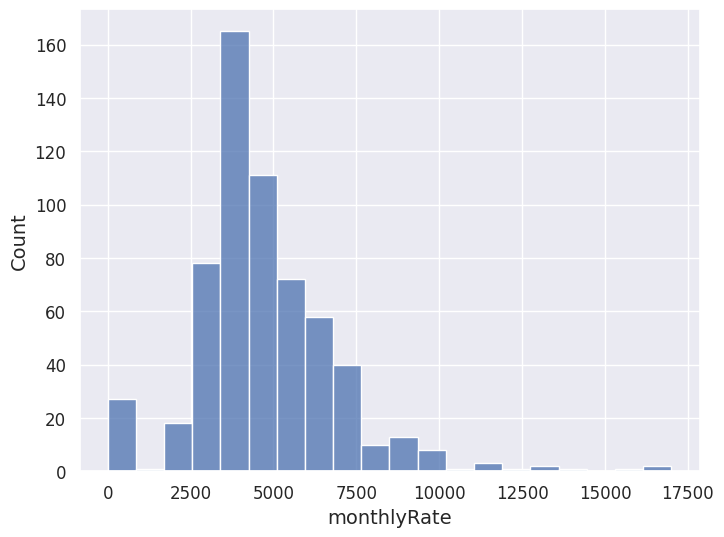

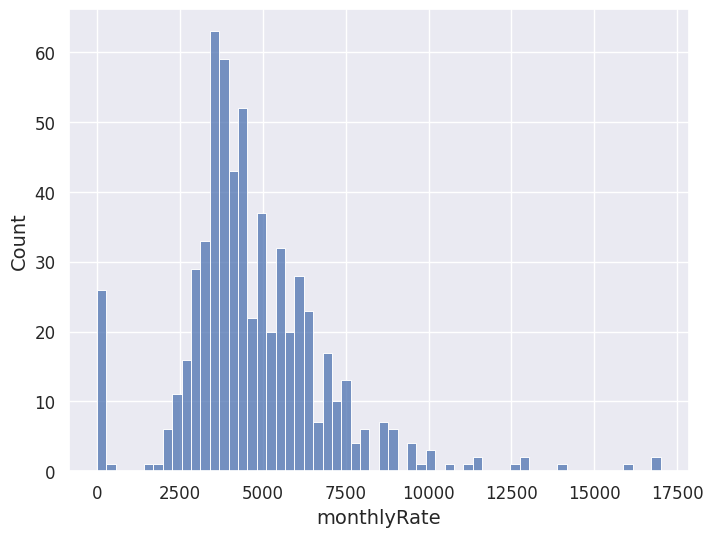

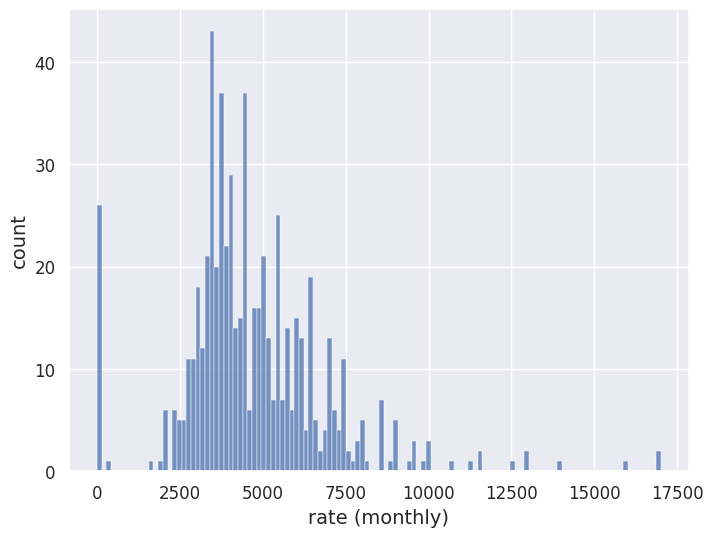

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.histplot(x='monthlyRate', data=part1_df, bins=20)
fig = plt.figure(figsize=(8,6))
sns.histplot(x='monthlyRate', data=part1_df, bins=60)
fig = plt.figure(figsize=(8,6))
sns.histplot(x='monthlyRate', data=part1_df, bins=120)
plt.xlabel("rate (monthly)")
plt.ylabel("count");




###**Question 2**
For 60 and 120 bins, you can see a repeating pattern of "peaks" and "vallies" in the distribution (mostly in the range between 500 and 7000). Is this pattern due to people rounding the rental prices? Please create a visualization that answers this question. Describe in words how the graph shows what the answer is (Hint: you can use the '%' operator to compute the remainder of dividing values in a pandas Series by a scalar number).

In [ ]:
# @title **extra hint**: please open this cell only after discussing with the course staff the best solution you could come up with

#
# Plot the distribution of values of the 'monthlyRate' column modulu (%) 1000
#

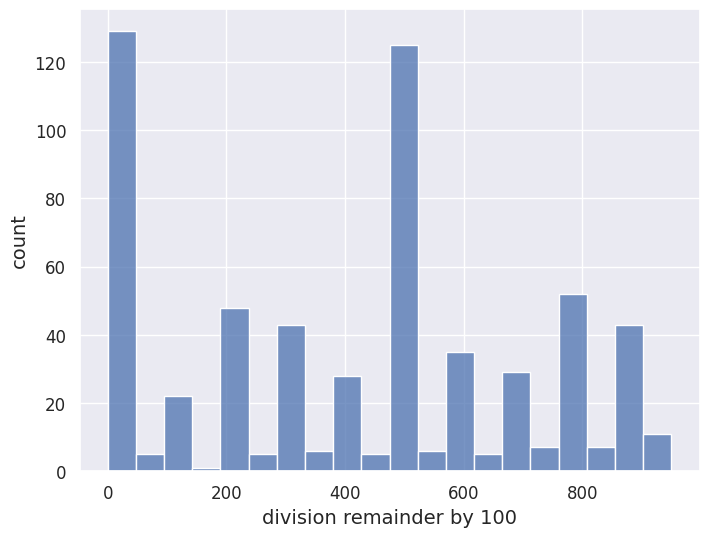

In [ ]:
part1_df["division remainder"] = part1_df["monthlyRate"]%1000
fig = plt.figure(figsize=(8,6))
sns.histplot(x='division remainder', data=part1_df, bins=20)
plt.xlabel("division remainder by 100")
plt.ylabel("count");



---
#### Part 1 Question 2 - textual Answer:
בדקתי על כל התצפיות מה תהיה שארית החלוקה כאשר נחלק את כל המחירים באלף. המסקנה שהגעתי אליה היא שרוב האנשים מעגלים בקפיצות של 500, אחר כך הרבה מעגלים לפי 100 ומעטים לפי 50.

---

###**Question 3**
We expect to see a "drop" in prices frequency near the 5000 Shekels mark due to tax considerations (See [here](https://www.kolzchut.org.il/he/%D7%A4%D7%98%D7%95%D7%A8_%D7%9E%D7%9E%D7%A1_%D7%A2%D7%9C_%D7%94%D7%9B%D7%A0%D7%A1%D7%94_%D7%9E%D7%94%D7%A9%D7%9B%D7%A8%D7%AA_%D7%93%D7%99%D7%A8%D7%94_%D7%9C%D7%9E%D7%92%D7%95%D7%A8%D7%99%D7%9D) for an explanation). Create a histogram visualization of the data with the smallest possible bins such that every bin will include exactly one multiplication of 500 (Hint: read the `bins` parameter documentation and what types it accepts). Explain why does this choice of bin size ensures that we will not see rounding effects. Do you see a "drop" around 5000 Shekels? Are there other "drops"?


<Axes: >

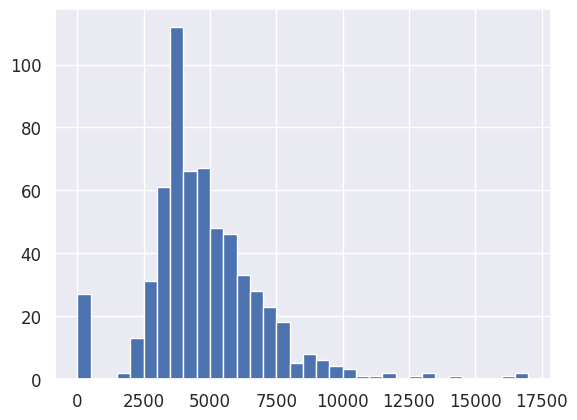

In [ ]:
part1_df["monthlyRate"].hist(bins=np.arange(0, max(part1_df["monthlyRate"]) + 500, 500))


---
#### Part 1 Question 3 - textual Answer:
אנשים מעגלים לרוב לפי 500 לכן כאשר אנחנו עושים קפיצות של 500 אנחנו מדוואים שהעמודות לא שכיחות יותר בגלל הנטיה לעגל.
ניתן לראות כי יש ירידה חדה אחרי שעוברים את ה-5000. בנוסף, הוא בשכיחות מאוד גבוהה כך שניתן להסיק כי אנשים שרוצים מעט יותר מ5000 מגבילים את עצמם ולכן יש שם הרבה תצפיות.

---

## Part 2: Size or number of rooms?

In [ ]:
# @title Part 2 - Create a DataFrame for Part 2

# Create the dataframe and remove the outliers we found in the intro part:
part2_df = rent_df_backup_for_exercise.copy()
part2_df = part2_df[part2_df['monthlyRate'] > 0].reset_index(drop=True);
part2_df = part2_df[part2_df['area'] < 800].reset_index(drop=True)
part2_df = part2_df[part2_df['area'] > 10].reset_index(drop=True)

We saw that both the number of rooms and the area of an apartment are strongly associated with the monthly rate. We now want to check if those are just two perspectives of the same relation (how big is the apartment) or is there something more to it. We will use the cleaned dataframe for this exercise.

**Use only `part2_df` for the coding questions in this part**


### **Question 1**
Generate a visualization to show that there is a strong association between the number of rooms and the area of the apartment. Explain your choice of plot type and your conclusion from the graph.


Text(0, 0.5, 'number of rooms')

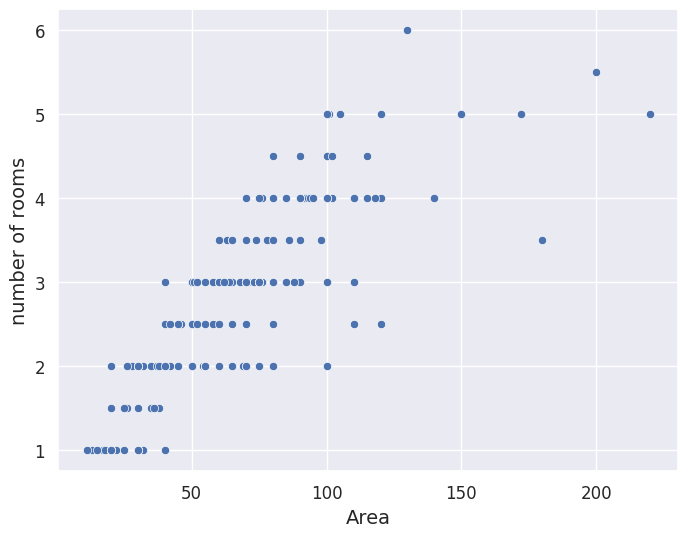

In [ ]:
# Part 2 - Question 1
plt.figure(figsize=(8,6))
sns.scatterplot(x='area', y='rooms', data=part2_df)
plt.xlabel("Area")
plt.ylabel("number of rooms")


---
#### Part 2 Question 1 - textual Answer:
בחרנו בגרף נקודות בגלל שרצינו לראות קוראלציות. נראה שיש קורלאציה חיובית חזרה בין שטח הדירה לכמות החדרים בה. נראה שהקוראלציה נחלשת ככל ששטח הדירה גדול יותר.

---

### **Question 2**
Add a new column to the dataframe named `"averageRoomSize"` with the average room size in the given listing.


In [ ]:
# Part 2 - Question 2
part2_df["averageRoomSize"] = (part2_df["area"] / part2_df["rooms"])
print(part2_df)


     propertyID neighborhood  monthlyRate mefarsem  rooms  floor   area  \
0       3994505   קריית יובל       2000.0  private    1.0    2.0   13.0   
1       3981298        רחביה       2450.0  private    1.0    1.0   17.0   
2       3981623         מלחה       2550.0  private    1.0    0.0   30.0   
3       3993997      בית וגן       2100.0  private    1.0    0.0   15.0   
4       3994399     פסגת זאב       2300.0  private    1.0    1.0   32.0   
..          ...          ...          ...      ...    ...    ...    ...   
268     3986876     רמת שלמה       5700.0  private    5.0    3.0  100.0   
269     3993009         רמות      10700.0  private    5.0    0.0  150.0   
270     3981999       תלפיות      13000.0  private    5.0    4.0  150.0   
271     3994215   קריית יובל       2900.0  private    2.0    0.0   40.0   
272     3972927  קריית שמואל       4900.0    agent    2.0    0.0   55.0   

          entry                                        description  numFloors  \
0    10/08/2022  י

###**Question 3**
Create a plot of the relation between the average room size and the monthly rate.

Text(0, 0.5, 'monthly Rate')

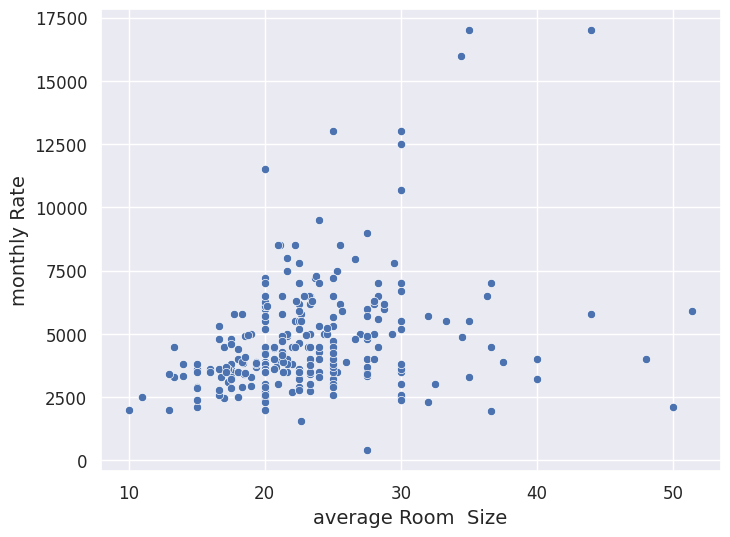

In [ ]:
# Part 2 - Question 3
plt.figure(figsize=(8,6))
sns.scatterplot(x='averageRoomSize', y='monthlyRate', data=part2_df)
plt.xlabel("average Room  Size")
plt.ylabel("monthly Rate")



### Question 4 - **bonus**
We can see that the variance of the monthly rate increases with the average room size.

Suggest what might be the reason for the increase in the variance and create a visualization to support or refute your suggestion.

Text(0, 0.5, 'area')

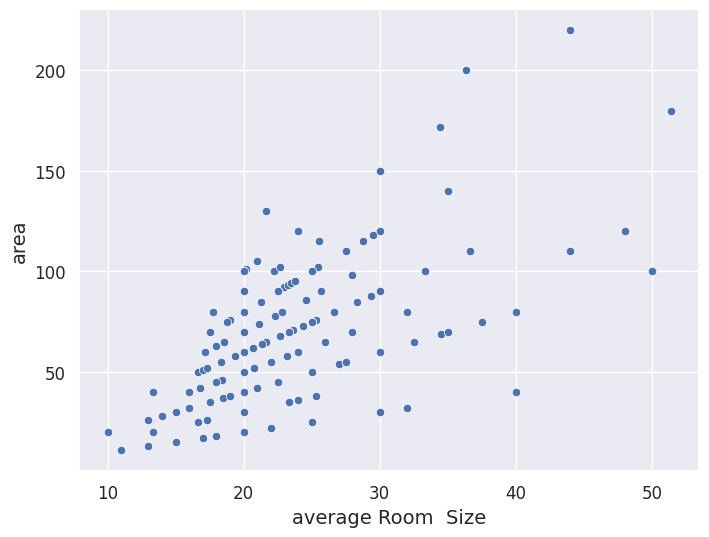

In [ ]:
# Part 2 - Question 4
plt.figure(figsize=(8,6))
sns.scatterplot(x='averageRoomSize', y='area', data=part2_df)
plt.xlabel("average Room  Size")
plt.ylabel("area")




---
#### Part 2 Question 4 - textual Answer:
ניתן לראות שככל שגודל החדרים עולה רואים יותר שונות בגודל הדירה בכללי. לכן, נראה גם יותר שונות במחירי הדירות.

---

## Part 3: Neighborhoods



In [ ]:
# @title Part 3 - Function Definitions and DataFrame Creation
def reverse_string(a):
  return a[::-1]


socialrank_df = load_df(SOCIORANK_ID)
neighborhood_ranks = {k: v for k,v in zip(socialrank_df['neighborhood'], socialrank_df['socioEconomicRank'])}

def get_neighborhood_rank(neighborhood):
  if neighborhood in neighborhood_ranks:
    return neighborhood_ranks[neighborhood]
  else:
    return None

# Create the dataframe and remove the outliers we found in the intro part:
part3_df = rent_df_backup_for_exercise.copy()
part3_df = part3_df[part3_df['monthlyRate'] > 0].reset_index(drop=True);
part3_df = part3_df[part3_df['area'] < 800].reset_index(drop=True)
part3_df = part3_df[part3_df['area'] > 10].reset_index(drop=True)
part3_df["neighborhood_flipped"] = part3_df["neighborhood"].apply(reverse_string) # making the neighborhood names readable

We now want to focus on the differences between different neighborhoods in Jerusalem.

**Use only `part3_df` for the coding questions in this part**

 *Use the `"neighborhood_flipped"` column for visualizations as seaborn will flip the order of letters in hebrew.

###**Question 1**
Print the number of unique neighborhoods that appear in the dataset.

In [ ]:
# Part 3 - Question 1
print(len(part3_df["neighborhood_flipped"].unique()))



46


###**Question 2**
Visualize the number of listings per neighborhood in a way that will allow you to easily identify those with the highest count.




<Axes: xlabel='neighborhood_flipped', ylabel='count'>

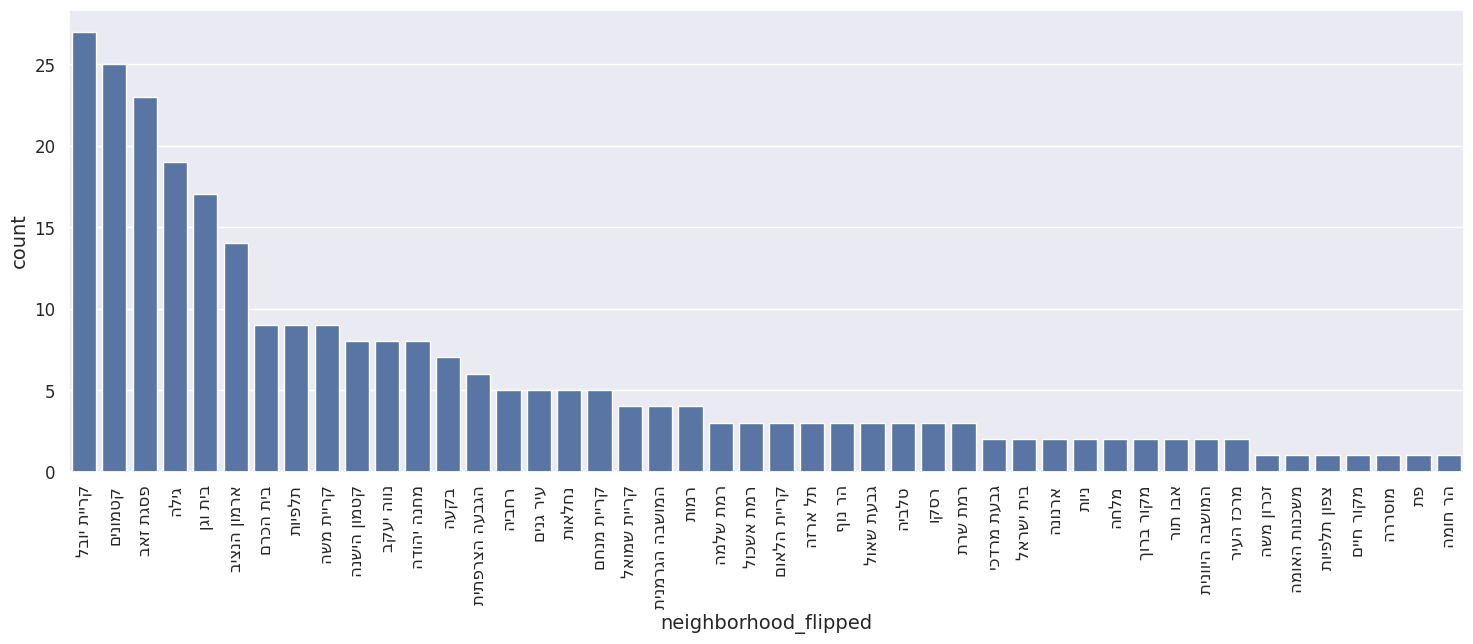

In [ ]:
sorted = list(part3_df['neighborhood_flipped'].value_counts(sort=True).keys())
plt.figure(figsize=(18,6))
plt.xticks(rotation=90)
sns.countplot(x='neighborhood_flipped', order=sorted, data=part3_df)




###**Question 3** - Heavy-tailed distributions
Print the number of neighborhoods with less than 5 listings and the fraction of their total number of listings out of the total number of listings. Also print the fraction of listings from the 8 most frequent neighborhoods out of the total number of listings.

In [ ]:
# Part 3 - Question 3
part3_df["number of listing"] = part3_df['neighborhood'].map(part3_df['neighborhood'].value_counts())
print("number of neighbrhoods with less then 5 listings")
print(len(part3_df[part3_df['number of listing'] < 5]['neighborhood'].unique()))
print("fraction of neighbrhoods with less then 5 listings")
print(part3_df[part3_df['number of listing'] < 5]["number of listing"].sum() / part3_df["number of listing"].sum())
print("fraction of the 8 most frequent neighbrhoods")
most_frequent_neighborhoods = part3_df['neighborhood'].value_counts().head(8).index
print(part3_df[part3_df['neighborhood'].isin(most_frequent_neighborhoods)]['number of listing'].sum() / part3_df["number of listing"].sum())

number of neighbrhoods with less then 5 listings
28
fraction of neighbrhoods with less then 5 listings
0.048849758591309286
fraction of the 8 most frequent neighbrhoods
0.8210735586481114


Those types of distributions where there are many categories that appear only a few times but together take a large portion of the distribution are called heavy-tailed (or long-tailed) distributions. This is a real issue in many data science applications, since even if we have a large dataset there are still some sub-populations or sub-categories that are not well represented.

###**Question 4**
Create a new filtered dataframe with listings from only the 8 most frequent neighborhoods.

In [ ]:
# Part 3 - Question 4
most_frequent_neighborhoods = part3_df['neighborhood'].value_counts().head(8).index
only8_df = part3_df[part3_df['neighborhood'].isin(most_frequent_neighborhoods)]
print(only8_df)


     propertyID neighborhood  monthlyRate mefarsem  rooms  floor   area  \
0       3994505   קריית יובל       2000.0  private    1.0    2.0   13.0   
3       3993997      בית וגן       2100.0  private    1.0    0.0   15.0   
4       3994399     פסגת זאב       2300.0  private    1.0    1.0   32.0   
11      3986231   קריית יובל       2600.0  private    1.0    1.0   30.0   
14      3992479   קריית יובל       2400.0  private    1.0    1.0   20.0   
..          ...          ...          ...      ...    ...    ...    ...   
262     3988577     פסגת זאב       6500.0  private    5.5    1.0  200.0   
264     3993965      בית וגן       7000.0  private    5.0    3.0  120.0   
266     3974914       תלפיות      17000.0  private    5.0    3.0  220.0   
270     3981999       תלפיות      13000.0  private    5.0    4.0  150.0   
271     3994215   קריית יובל       2900.0  private    2.0    0.0   40.0   

          entry                                        description  numFloors  \
0    10/08/2022  י

###**Question 5**
Plot a graph to check whether there are different distributions of monthly rates in the eight neighborhoods. Explain your choice for the visualization and your conclusions.
Note: Make sure that the neighborhoods are ordered in the plot based on their tendency for higher or lower monthly rates.

Hint: Which is a better descriptor of the central tendency of monthly rates when the distributions are skewed?

Text(0, 0.5, 'rate')

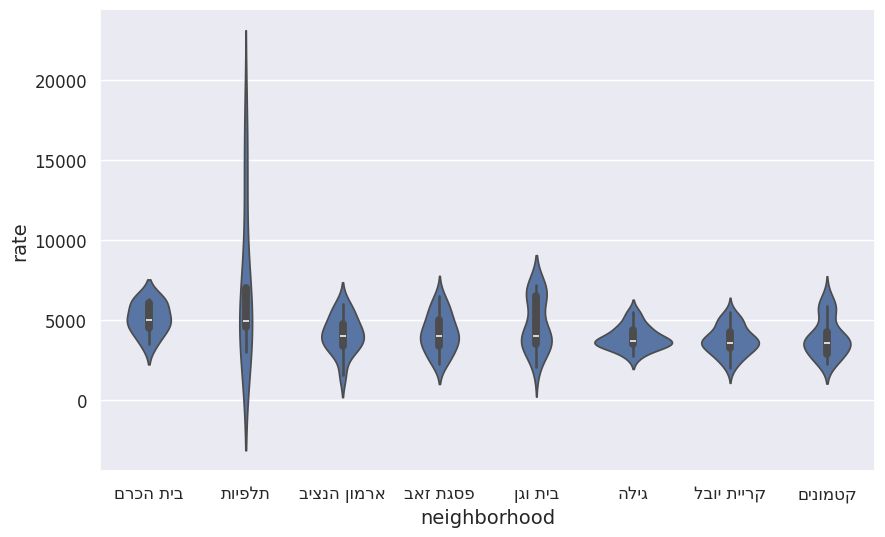

In [ ]:
# Part 3 - Question 5
most_frequent_neighborhoods = part3_df['neighborhood_flipped'].value_counts().head(8).index
only8_df = part3_df[part3_df['neighborhood_flipped'].isin(most_frequent_neighborhoods)]
median_rates = only8_df.groupby('neighborhood_flipped')['monthlyRate'].median()
sorted_neighborhoods = median_rates.sort_values(ascending=False).index
plt.figure(figsize=(10, 6))
sns.violinplot(x='neighborhood_flipped', y='monthlyRate', data=only8_df, order=sorted_neighborhoods)
plt.xlabel("neighborhood")
plt.ylabel("rate")



---
#### Part 3 Question 5 - textual Answer:
בחרנו בגרף כינור בגלל שהוא מציג לנו אתכל התצפיות וההתפלגויות שלהן. ככה אנחנו יכולים לדעת את האזורים השכיחים יותר ואת תצפיות הקיצון. את התצפיות סידרנו לפי הסדר של החציון מכיוון שהחציון אינו מוטה בעקבות תצפיות קיצון וניתן לראות כי החציון של כל התצפיות יחסית שווה.

---

### **Question 6**
Now that we compared the different distributions of monthly rates betwen neighborhoods, we can check whether we can explain some of the differences using our common-sense and the data we already have.
For example, perhaps different neighborhoods have different distributions of apartment sizes?

Think of a new variable that will allow you to check the relationship between neighborhoods and prices fairly, factoring different apartment sizes out of the equation. Save this measure into the dataframe and create a new visualization to answer the question.


<ipython-input-88-353acf99dab4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only8_df["price for square area"] = (only8_df["monthlyRate"]/only8_df["area"])


Text(0, 0.5, 'price for square area')

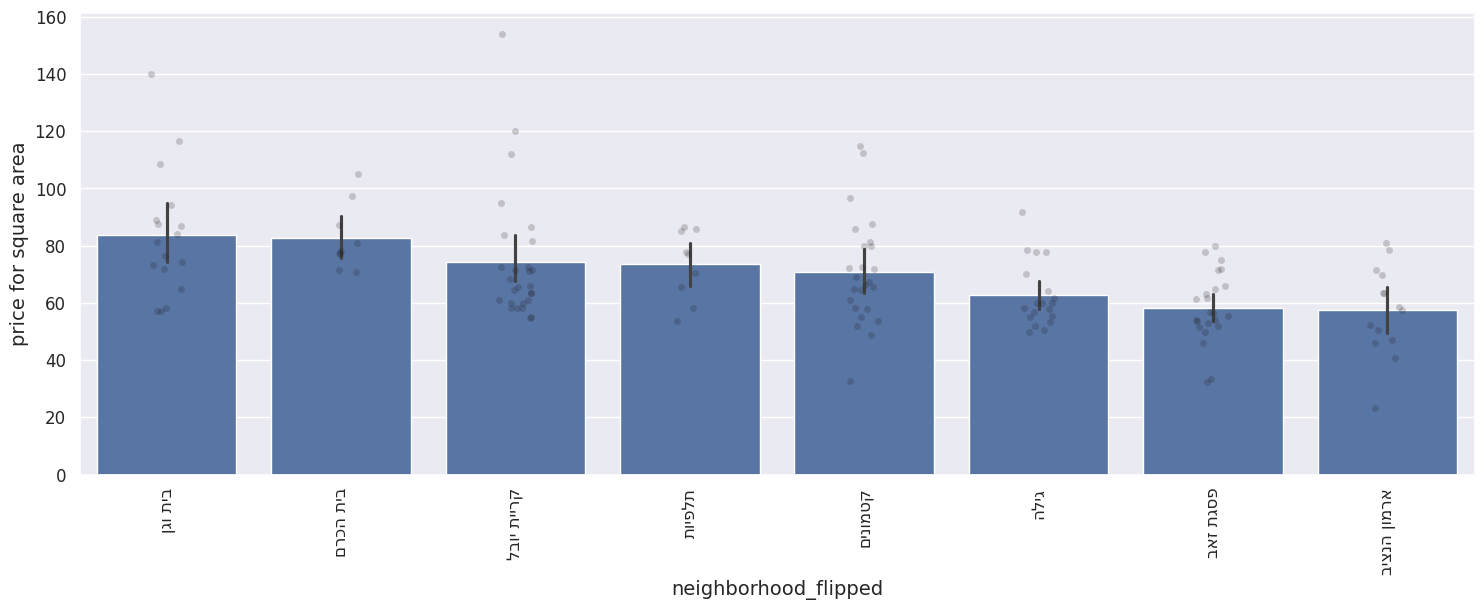

In [ ]:
# Part 3 - Question 6
only8_df["price for square area"] = (only8_df["monthlyRate"]/only8_df["area"])
median_price_per_area = only8_df.groupby('neighborhood_flipped')['price for square area'].mean()
sorted_neighborhoods = median_price_per_area.sort_values(ascending=False).index
plt.figure(figsize=(18,6))
plt.xticks(rotation=90)
sns.barplot(x='neighborhood_flipped', y='price for square area', order=sorted_neighborhoods, data=only8_df)
sns.stripplot(x='neighborhood_flipped', y='price for square area', order=sorted_neighborhoods, data=only8_df, alpha=0.2, color='k')
plt.xlabel("neighborhood_flipped")
plt.ylabel("price for square area")



---
#### Part 3 Question 6 - textual Answer:
בכדי לבחון האם יש שכונות יקרות יותר מאחרות ולנטרל את גודל הדירה בחנו את המחיר לכל דירה באמצעות מחיר למטר רבוע.
לאחר מכן הצגנו את הממצעים בגרף עמודות ממוין לפי הממוצע והצגנו את התצפיות.
נראה כי יש הבדלים משמעותיים בין השכונות היקרות ביותר לשכונות הכי פחות יקרות

---

Given the conclusions from the previous steps, we may think that the apartment's neighborhood gives us additional information about the expected monthly rate. But the sample size for most neighborhoods is rather small. So let's examine another way to utilize the location information. Luckily, we also have data about the socio-economic rank of most neighborhoods (between 1 and 10).

### Question 7 - **bonus**
Use again the full dataset (without filtering by neighborhood).

Create an aggregated dataframe where every record represents a neighborhood, with columns for:
1. neighborhood name
2. flipped neighborhood name
3. The number of listings in a neighborhood
4. The median monthly rate for listings in this neighborhood.

Add a column with the neighborhood socio-economic rank to the dataframe (you can use the provided `get_neighborhood_rank` function that takes as an input a neighborhood name and returns its socio-economic rank.) Use this dataframe to visualize the association between socio-economic rank and pricing for all neighborhoods with at least 5 listings. What is you conclusion?

Text(0, 0.5, 'median monthly rate')

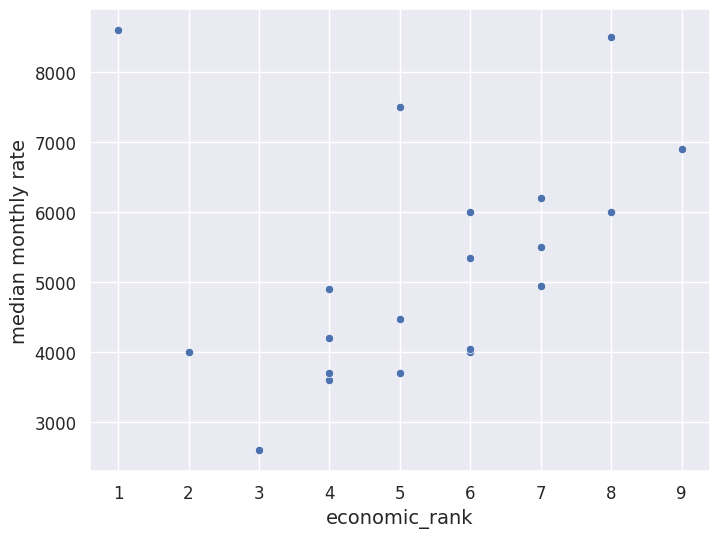

In [ ]:
# Part 3 - Question 7
part3q7_df = pd.DataFrame({'neighborhood': part3_df['neighborhood'].unique(),'neighborhood_flipped': part3_df['neighborhood_flipped'].unique()})
part3q7_df["listing_num"] = part3_df['neighborhood'].map(part3_df['neighborhood'].value_counts())
part3q7_df["median monthly rate"] = part3q7_df['neighborhood'].map(part3_df.groupby('neighborhood')['monthlyRate'].median())
part3q7_df["economic_rank"] = part3q7_df['neighborhood'].apply(get_neighborhood_rank)

part3q7_df = part3q7_df[part3q7_df["listing_num"] >= 5]

plt.figure(figsize=(8,6))
sns.scatterplot(x='economic_rank', y='median monthly rate', data=part3q7_df)
plt.xlabel("economic_rank")
plt.ylabel("median monthly rate")




---
#### Part 3 Question 7 - textual Answer:
נראה כי יש מתאם חיובי בין הרמה הסוציואקונוממית של השכונה לבין המחיר החציוני לחודש.
---

## Part 4: Are private houses more expensive than apartments?

In [ ]:
# @title Part 4 - Create a DataFrame and remove outliers for Part 4
part4_df = rent_df_backup_for_exercise.copy()
part4_df = part4_df[part4_df['monthlyRate'] > 0].reset_index(drop=True);
part4_df = part4_df[part4_df['area'] < 800].reset_index(drop=True)
part4_df = part4_df[part4_df['area'] > 10].reset_index(drop=True)

Finally, we want to check if listings in private houses tend to be more expensive than apartments in a building.

**Use only `part4_df` for the coding questions in this part**

### **Question 1**
The current dataset doesn't include a variable that describes whether a listing is in a building or a private house but this can be inferred from the existing variables. Create a new column named "is_a_house" with value of `True` if a listing is in the first (or zero) floor in a building with only one floor. Print the number of private houses and print the descriptions of three random listings with 'is_a_house' equal to `True`.

In [ ]:
# Part 4 - Question 1
part4_df["is_a_house"] = False
part4_df.loc[(part4_df['numFloors'] == 1) & ((part4_df['floor'] == 0) | (part4_df['floor'] == 1)), 'is_a_house'] = True
print(len(part4_df["is_a_house"][part4_df["is_a_house"] == True]))
print(part4_df[part4_df["is_a_house"] == True].sample(3))


17
     propertyID   neighborhood  monthlyRate mefarsem  rooms  floor   area  \
92      3882274       פסגת זאב       2400.0  private    2.0    1.0   30.0   
171     3982071  הגבעה הצרפתית       7000.0  private    3.0    0.0  110.0   
48      3985356           גילה       3600.0  private    2.0    1.0   60.0   

          entry                                        description  numFloors  \
92   10/08/2022  יחידת דיור מוארת,  משופצת  . כניסה פרטית! דירה...        1.0   
171  10/08/2022  דירה ברחוב שקט חנייה בשפע  כניסה פרטית , מרפסת...        1.0   
48   10/08/2022  מקום מדהים ,קומה ראשונה,תחנת אוטובוס,גני ילדים...        1.0   

     is_a_house  
92         True  
171        True  
48         True  


### **Question 2**
Create a visualization that compares the **average** monthly rates in houses vs. apartments. Which are more expensive on average?

<ipython-input-93-0d0aad382fcf>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['apartment', 'House'])


[Text(0, 0, 'apartment'), Text(1, 0, 'House')]

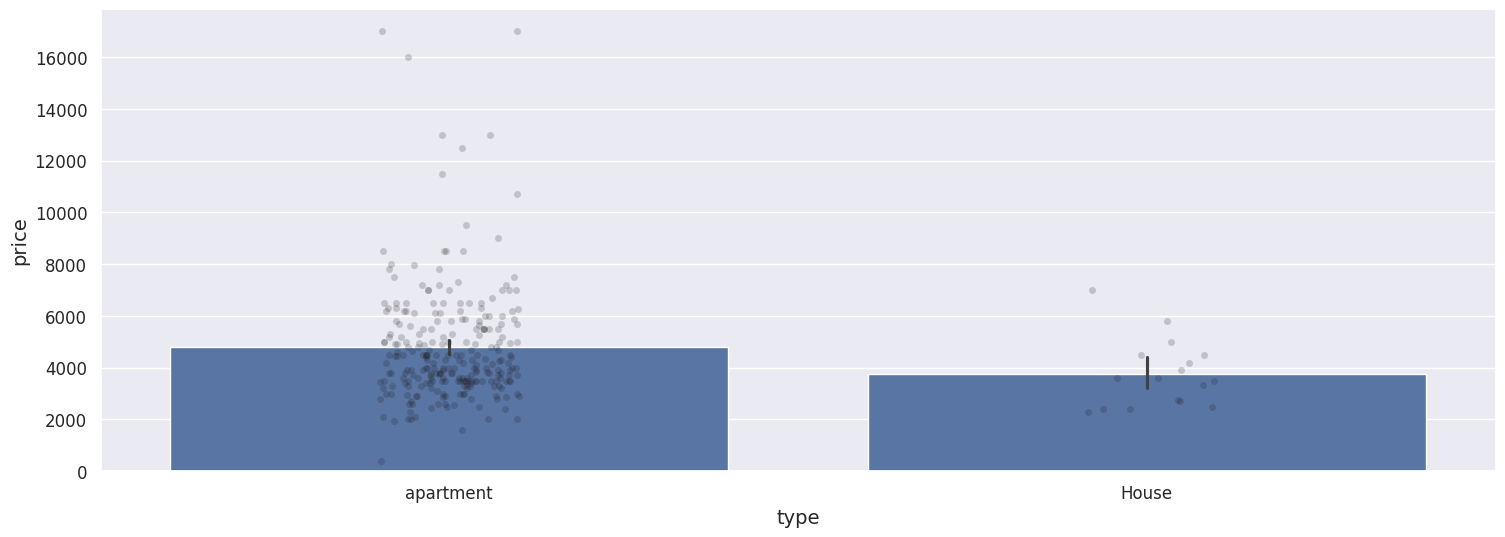

In [ ]:
plt.figure(figsize=(18,6))
sns.barplot(x='is_a_house', y = "monthlyRate", data=part4_df)
sns.stripplot(x='is_a_house', y='monthlyRate', data=part4_df, alpha=0.2, color='k')
plt.xlabel("type")
plt.ylabel("price")
ax = plt.gca()
ax.set_xticklabels(['apartment', 'House'])




---
#### Part 4 Question 2 - textual Answer:
נראה כי בממוצע דירות נוטות להיות ייקרות יותר.

---

###**Question 3**  
Now, let's look at the data in a higher resolution. Create a visualization that compares the average monthly rates of houses vs. apartments separetly for any number of rooms. Do the results align with the results from the previous question?

<ipython-input-79-f4a03ff7c08b>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['apartment', 'House'])


[Text(0, 0, 'apartment'), Text(1, 0, 'House')]

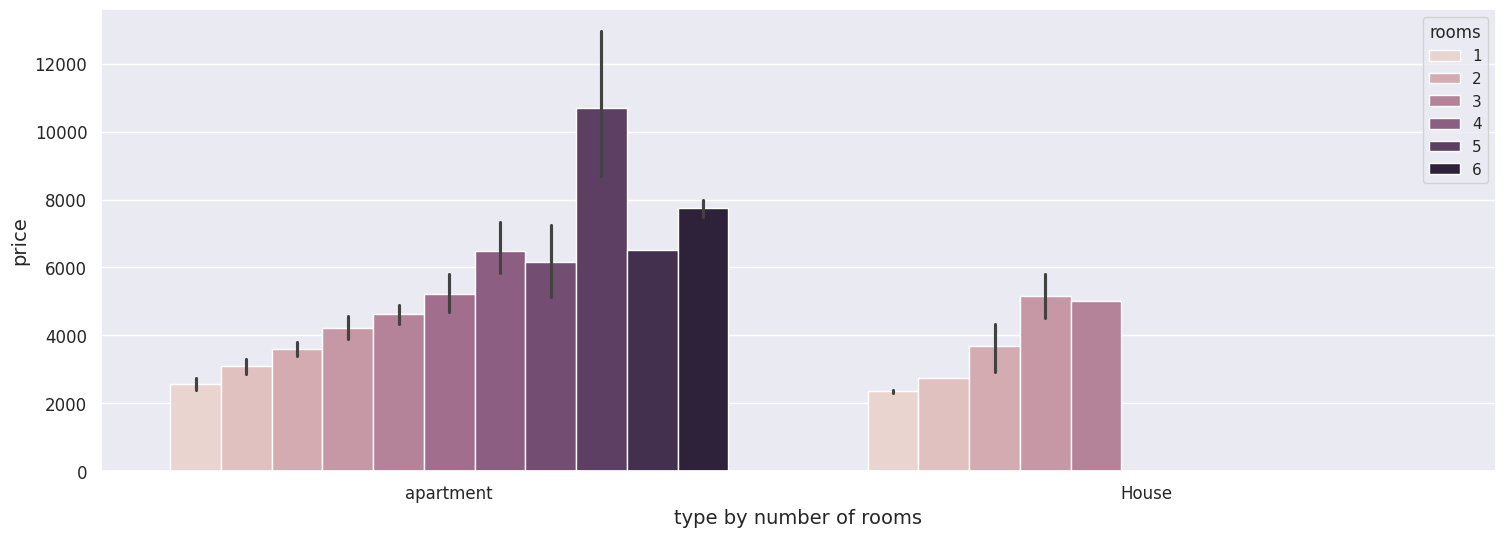

In [ ]:
# Part 4 - Question 3
plt.figure(figsize=(18,6))
sns.barplot(x='is_a_house', y='monthlyRate', hue='rooms', data=part4_df)
plt.xlabel("type by number of rooms")
plt.ylabel("price")
ax = plt.gca()
ax.set_xticklabels(['apartment', 'House'])



---
#### Part 4 Question 3 - textual Answer:
נראה כי בבתים פרטיים יש פחות חדרים ובגלל זה המחירים נמוכים יותר בממוצע.

---

### **Question 4**
Dan saw those visualizations and suggested that the trend in **question 2** is due to the fact that apartments in this dataset have larger maximal number of rooms than houses.

Create a new visualization similar to **question 2**, but consider only apartment listings with a number of rooms less or equal to the maximal number of rooms for a private house listing. Does the result now align with the trend in **question 3**? If not, is the discrapancy smaller than before?

<ipython-input-82-1e26e1e7eb25>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['apartment', 'House'])


[Text(0, 0, 'apartment'), Text(1, 0, 'House')]

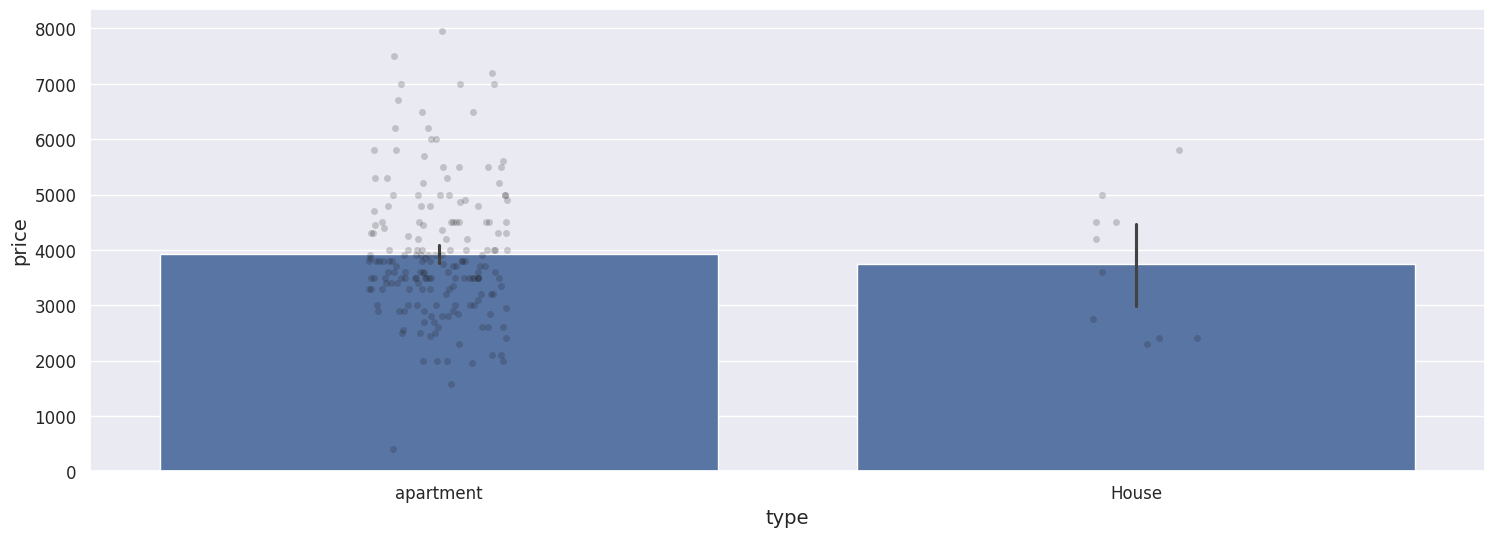

In [ ]:
# Part 4 - Question 4
plt.figure(figsize=(18,6))
max_houses = max(part4_df['rooms'][part4_df['is_a_house']== True])
up_to_max = part4_df[part4_df['rooms'] <= max_houses]
sns.barplot(x='is_a_house', y = "monthlyRate", data=up_to_max)
sns.stripplot(x='is_a_house', y='monthlyRate', data=up_to_max, alpha=0.2, color='k')
plt.xlabel("type")
plt.ylabel("price")
ax = plt.gca()
ax.set_xticklabels(['apartment', 'House'])



---
#### Part 4 Question 4 - textual Answer:
אחרי שהורדנו בתים עם יותר חדרים מהמקסימום של הבתים הפרטיים נראה כי הממוצעים כן שווים.

---

###**Question 5**
Create a visualization that compares the proportion of listings with every value of "number of rooms" in each of the two groups (is_a_house == True and is_a_house == False). How can the results here explain the discrapancy between the results of **question 2** and **question 3**? (Hint: recall the UC Berkeley admission rates example from the first lecture)

<Figure size 1800x600 with 0 Axes>

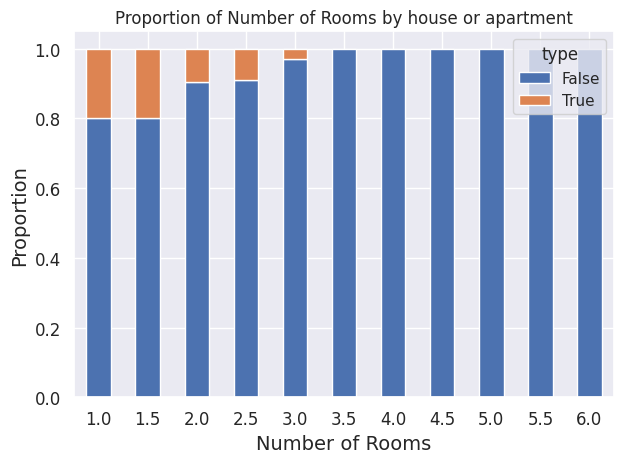

In [ ]:
# Part 4 - Question 5
plt.figure(figsize=(18,6))
prop_table = part4_df.groupby('rooms')['is_a_house'].value_counts(normalize=True).unstack()
prop_table.plot(kind='bar', stacked=True)
plt.title('Proportion of Number of Rooms by house or apartment')
plt.xlabel('Number of Rooms')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='type')
plt.tight_layout()


---
#### Part 4 Question 5 - textual Answer:
הנתונים פה מסבירים את ההבדל בין התשובות השונות שיצאו לנו כי אנחנו צריכים להסתכל על שיעורי הבסיס שלנו ועל כמה תצפיות יש לנו מכל אחד מהסוגים כדי להגיע להחלטה. יש יותר דירות גדולות יותר שיטו לנו את המחירים למעלה והבתים שמושכרים הם יחסית עם מעט חדרים.

---